# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import sin, pi, arange
from nltools.external import glover_hrf

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

import scipy.misc
from scipy import ndimage
from ipywidgets import interact_manual, interact

Load the functional image of the first subject.

In [25]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [26]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

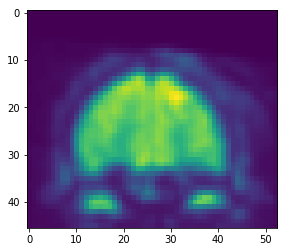

In [27]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[:,55,:,10], 90))

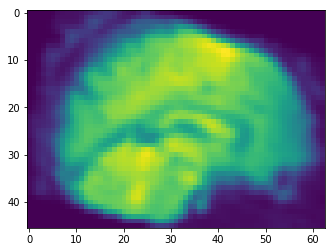

In [28]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[25,:,:,0], 90))

Let's load the mask data for this subject.

In [29]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [30]:
mask.get_fdata().shape

(53, 63, 46)

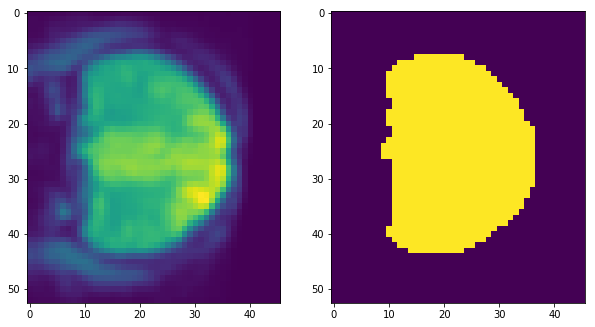

In [31]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

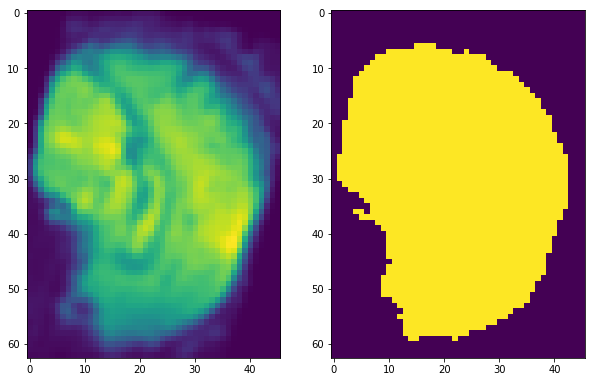

In [32]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

# Exercise 

For each of the question below, use your code to perform the analysis.

## Which regions are more involved with visual compared to auditory sensory processing?

First, we need the localizer study data:

In [33]:
# (seconds)
total_scan_time = 300 # five minutes

# (milliseconds)
onset_times = [0,2400,5700,8700,11400,15000,18000,20700,23700,26700,29700,33000,35400,39000,41700,44700,48000,
        50700,53700,56400,59700,62400,66000,69000,71400,75000,78000,80400,83400,87000,89700,93000,96000,
        99000,102000,105000,108000,110400,113700,116700,119400,122700,125400,129000,131400,135000,137700,
        140400,143400,146700,149400,153000,156000,159000,162000,164400,167700,170400,173700,176700,179700,
        182700,186000,188400,191700,195000,198000,201000,203700,207000,210000,212700,215700,218700,221400,
        224700,227700,230700,234000,236700,240000,243000,246000,248400,251700,254700,257400,260400,264000,
        266700,269700,272700,275400,278400,281700,284400,288000,291000,293400,296700]

# onset type (one-based index)
onset_types = [8,8,11,1,3,10,5,10,4,6,10,2,7,9,9,7,7,11,11,9,
        1,4,11,5,6,9,11,11,7,3,10,11,2,11,11,11,7,11,11,6,
        10,2,8,11,9,7,7,2,3,10,1,8,2,9,3,8,9,4,7,1,
        11,11,11,1,7,9,8,8,2,2,2,6,6,1,8,1,5,3,8,10,
        11,11,9,1,7,4,4,8,2,1,1,11,5,2,11,10,9,5,10,10]

localizer_labels = ['horizontal_checkerboard',
          'vertical_checkerboard',
          'motor_right_auditory',          
          'motor_left_auditory',
          'motor_right_visual',          
          'motor_left_visual',
          'subtraction_auditory',
          'subtraction_visual',          
          'sentence_visual',   
          'sentence_auditory']

def get_localizer_design_data():

    # onset type
    onset_types_0_based = np.array(onset_types) - 1
    
    events = list(zip(onset_times, onset_types_0_based))
    
    # ignore the last onset type
    events = [(onset_time, onset_type) for (onset_time, onset_type) in events if onset_type != 10]
    
    return (events, localizer_labels)

events, labels = get_localizer_design_data()

Next, let's dump all our functions from the last lab:

In [34]:
## Returns a univariate time series that is a design vector for one event type
def compute_design_vector(events, event_index, num_time_slices=128, tr=2.4):
    selected_onset_times = [onset_time for onset_time, onset_type in events if onset_type == event_index]
    iss = np.floor(np.array(selected_onset_times) / (tr * 1000)).astype(int)                 
    line = np.zeros(num_time_slices)
    line[iss] = 1
    return line

#----DesignMatrixUtils------------------------------------------------------------------------------------
class DesignMatrixUtils:
    pass

## Returns a design matrix: a pandas dataframe where each column is an event design vector
def create_design_matrix(events, labels, tr=2.4, duration=128): 
    df = pd.DataFrame(columns=labels)
    for i in range(len(labels)):
        line = compute_design_vector(events, i, duration, tr).astype('int')
        df[labels[i]] = line
    return df

DesignMatrixUtils.create_design_matrix = create_design_matrix

## Plots a design matrix. Each column (or row, depending on orientation) is a design vector
def plot(design_matrix, orientation = 'horizontal'):  
    values = design_matrix.values 
    labels = design_matrix.columns
    m = len(labels)
    if orientation == 'vertical':
        f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)
    elif orientation == 'horizontal':
        f, a = plt.subplots(nrows=m, figsize=(10, m), sharex=True)
    else:
        raise Exception("Invalid orientation") 
    times = range(values.shape[0])
    for i in range(0, m):        
        label = labels[i]
        
        if orientation == 'vertical':
            a[i].plot(values[:,i], times)
            a[i].set_title(label, fontsize=12, rotation=45)
        else:
            a[i].plot(times,values[:,i])
            a[i].set_title(label, fontsize=12)
    if orientation == 'vertical':
        plt.gca().invert_yaxis()
    plt.tight_layout()
    return

DesignMatrixUtils.plot = plot

## Returns a subset of a design matrix containing only events with "[task]" in their name
def select_tasks_with_name(design_matrix, task):
    selected_tasks = [col for col in design_matrix.columns if task in col]
    return design_matrix[selected_tasks]

DesignMatrixUtils.select_tasks_with_name = select_tasks_with_name

## Plots a design matrix using a heatmap
def heatmap(design_matrix):     
    sns.heatmap(design_matrix)
    return

DesignMatrixUtils.heatmap = heatmap

## Adds an intercept column to a design matrix
def add_intercept(design_matrix):  
    design_matrix_copy = design_matrix.copy()
    n_rows, n_cols = design_matrix.shape
    design_matrix_copy['intercept'] = np.ones(n_rows)
    return design_matrix_copy

DesignMatrixUtils.add_intercept = add_intercept

## Adds polynomial columns to a design matrix
def add_poly(design_matrix, degrees=2, flipped=False):
    frames = design_matrix.shape[0]
    time = np.linspace(-1, 1, frames)
    for i in range(degrees+1):
        key = '1-poly%d'%(i) if flipped else 'poly%d'%(i)
        design_matrix[key] = (time ** i) * (-1 if flipped else 1)
    return design_matrix

DesignMatrixUtils.add_poly = add_poly

## Adds a cosine column to a design matrix
def add_cosine(design_matrix, freq, amplitude, phase = 0):     
    duration = design_matrix.shape[0]
    time = np.linspace(0, 1, duration)
    w = amplitude * sin(2*pi*freq*time + pi*phase)
    copy = design_matrix.copy()
    copy['cos'+str(freq)] = w
    return copy
    ### END SOLUTION
DesignMatrixUtils.add_cosine = add_cosine

## Convolves each column in a design matrix with the hrf function
def convolve_hrf(design_matrix, tr=2.4):     
    design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
    hrf = glover_hrf(tr, oversampling=1) 
    labels = design_matrix.columns
    for label in labels:
        design_matrix_copy[label] = np.convolve(design_matrix_copy[label].to_numpy(), hrf, mode='same') 
    return design_matrix_copy

DesignMatrixUtils.convolve_hrf = convolve_hrf

## Returns a design matrix with all functions in [funcs] applied to it
def add_many(design_matrix, funcs = []):     
    design_matrix_copy = design_matrix.copy() # Avoid modifying the original dataframe
    for func in funcs:
        design_matrix_copy = func(design_matrix_copy)
    return design_matrix_copy
    
DesignMatrixUtils.add_many = add_many


#----1D GLM------------------------------------------------------------------------------------
## Plots toy 1D brain data as a series of 1D images (through time, going down)
def plot_functional_data_1d(data):
    plt.figure(figsize=(40,4))
    n_tr = data.shape[2]
    c = int(n_tr/2)
    times = [0,1,2,3,4,5] + [c,c+1,c+2,c+3,c+4,c+5]
    m = len(times)
    for i, time in enumerate(times):
        axes = plt.subplot(m,1,i+1)
        plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
        plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
        axes.get_yaxis().set_ticks([])
        
## Given a design matrix and a one-hot vector of betas 
## (of length equal to number of labels (columns) in the design matrix), 
## returns a univariate time series showing each time a beta value spikes (spikes equal value in corresponding d_s column * corresponding beta)
def generate_time_series(design_matrix, betas):
    y = np.zeros(design_matrix.shape[0])    
    for col, beta in zip(design_matrix.columns, betas):
        y = y + design_matrix[col] * beta
    return y

## We compute GLM regression using this function
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

## Compute a beta map for a toy example of 1D images
def compute_beta_map(data, X):
    size = data.shape[1]
    n_regressors = X.shape[1]
    beta_map = np.zeros((1,size,n_regressors))    
    for i in range(size):
        Y = data[0,i,:]
        bs = estimate_beta(X, Y)
        beta_map[0,i,:] = bs
    return beta_map

## Plot a beta map for a 1D toy example 
def plot_beta_map_1d(beta_map, design_matrix):
    plt.figure(figsize=(40,4))
    labels = design_matrix.columns
    m = len(labels)    
    for i, label in enumerate(labels):
        axes = plt.subplot(m,1,i+1)
        plt.imshow(beta_map[:,:,i], cmap='bwr', vmin=-1, vmax=1)
        plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
        axes.get_yaxis().set_ticks([])
        
## Given a beta map and a vector of contrasts
## (of the length of the number of betas,
## assigning positive values to events in one group and negative values to events in another group),
## returns a contrast map
def compute_contrast(beta_map, contrast):       
    b = np.squeeze(beta_map)   
    c = np.array(contrast).T
    cs = np.dot(b,c).T 
    # expand cs to a 2D-array so that we can show it using imshow
    cs = np.expand_dims(cs, axis=0)
    return cs

## Computes a contrast map then plots it
def show_contrast(beta_map, contrast):
    cs = compute_contrast(beta_map, contrast)
    plt.figure(figsize=(40,2))
    plt.imshow(cs, cmap='gray')

#----2D GLM------------------------------------------------------------------------------------
from scipy.ndimage.filters import gaussian_filter

class FunctionalDataSim2D:
    @staticmethod
    def create(height, weight, n_tr):
        data = np.zeros((height, weight, n_tr))
        return data
    
    @staticmethod
    def plot_data(data, selected = None):
        times = selected
        m = len(times)
        plt.figure(figsize=(8*m,4))
        
        for i, time in enumerate(times):
            axes = plt.subplot(m,1,i+1)
            plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
            plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
            axes.get_yaxis().set_ticks([])
        return
    
    @staticmethod
    # mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
    def add(data, design_matrix, betas, locations):
        for i in range(len(locations)):
            time_series = generate_time_series(design_matrix, betas)
            data[locations[i][0],locations[i][1],:] = time_series
        return
    
    @staticmethod
    def plot_beta_map(beta_map, design_matrix):
        betas = beta_map.shape[2]
        plt.figure(figsize=(8*betas,8))
        
        for i, beta in enumerate(range(betas)):
            axes = plt.subplot(betas,1,i+1)
            plt.imshow(beta_map[:,:,beta], vmin=-1, vmax=1, cmap='bwr')
            plt.ylabel(design_matrix.columns[i], fontsize=10, rotation=0, labelpad=50, va='center')
            axes.get_yaxis().set_ticks([])
        return
    
    def compute_beta_map(data, X):
        n_regressors = X.shape[1]
        beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors)) 
        
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                for k in range (data.shape[2]):
                    Y = data.get_fdata()#data[i,j,:]
                    bs = estimate_beta(X, Y)
                    beta_map[i,j,:] = bs
        return beta_map
    
    @staticmethod
    def show_contrast(beta_map, contrast):
        cs = compute_contrast(beta_map, contrast).squeeze().T
        plt.figure(figsize=(40,2))
        plt.imshow(cs.squeeze(), cmap='gray')
        
    @staticmethod
    def show_contrast_with_threshold(beta_map, contrast, threshold):
        cs = compute_contrast(beta_map, contrast).squeeze().T
        maximum = cs.max()
        cs[cs < maximum*threshold] = 0
#         cs[cs >=maximum*threshold] = 1
        cs[mask] = 0 # Everywhere that mask is 1, cs will be set to 0
        plt.figure(figsize=(40,2))
        plt.imshow(cs.squeeze(), cmap='gray')
        return cs
    
    @staticmethod
    def smooth(data):
        for i in range(data.shape[2]):
            data[:,:,i] = gaussian_filter(data[:,:,i],sigma=[1,1])
        return





### Next let's start code for 3D GLM:

In [35]:
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits import mplot3d
import scipy.misc
from scipy import ndimage

class FunctionalData3D:
    
    @staticmethod
    def plot_data(data, selected = None, axis='x', pos=0):
        times = selected
        m = len(times)
        plt.figure(figsize=(10*m,20))
        
        for i, time in enumerate(times):            
            if (axis=='x' or axis=='X'):
                axes = plt.subplot(m,1,i+1, xlabel='Y', ylabel='Z')
                imgX = data.get_fdata()[pos,:,:,time]
                plt.imshow(ndimage.rotate(imgX, 90))
            if (axis=='y' or axis=='Y'):
                axes = plt.subplot(m,1,i+1, xlabel='X', ylabel='Z')
                imgY = data.get_fdata()[:,pos,:,time]
                plt.imshow(ndimage.rotate(imgY, 90))
            if (axis=='z' or axis=='Z'):
                axes = plt.subplot(m,1,i+1, xlabel='X', ylabel='Y')
                imgZ = data.get_fdata()[:,:,pos,time]
                plt.imshow(ndimage.rotate(imgZ, 90))
            
            plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
            axes.get_yaxis().set_ticks([])
        return
    
    @staticmethod
    # mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
    def add(data, design_matrix, betas, locations):
        for i in range(len(locations)):
            time_series = generate_time_series(design_matrix, betas)
            data[locations[i][0],locations[i][1],:] = time_series
        return
    
    @staticmethod
    def plot_beta_map(beta_map, design_matrix): # TODO: rewrite for 3D
        betas = beta_map.shape[2]
        plt.figure(figsize=(8*betas,8))
        
        for i, beta in enumerate(range(betas)):
            axes = plt.subplot(betas,1,i+1)
            plt.imshow(beta_map[:,:,beta], vmin=-1, vmax=1, cmap='bwr')
            plt.ylabel(design_matrix.columns[i], fontsize=10, rotation=0, labelpad=50, va='center')
            axes.get_yaxis().set_ticks([])
        return
    
    def compute_beta_map(data, X): # TODO: rewrite for 3D
        n_regressors = X.shape[1]
        beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors)) 
        
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                for k in range (data.shape[2]):
                    Y = data.get_fdata()[i,j,k,:]#data[i,j,:]
                    bs = estimate_beta(X, Y)
                    beta_map[i,j,k,:] = bs
        return beta_map
    
    @staticmethod
    def show_contrast(beta_map, contrast, axis='x', pos=0): # TODO: rewrite for 3D
        cs = compute_contrast(beta_map, contrast).squeeze().T
        plt.figure(figsize=(40,2))
        
        if (axis=='x' or axis=='X'):
            imgX = cs[pos,:,:].squeeze()
            plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
            #plt.imshow(ndimage.rotate(mask.get_fdata()[pos,:,:], 90), alpha=0.5)
        if (axis=='y' or axis=='Y'):
            imgY = cs[:,pos,:].squeeze()
            plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
        if (axis=='z' or axis=='Z'):
            imgZ = cs[:,:,pos].squeeze()
            plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
        #plt.imshow(cs[:,2,:].squeeze(), cmap='gray')
        
    @staticmethod
    def show_contrast_with_threshold(beta_map, contrast, axis='x', pos=0, threshold=0.5):
        cs = compute_contrast(beta_map, contrast).squeeze().T
        maximum = cs.max()
        cs[cs < maximum*threshold] = 0
        plt.figure(figsize=(40,2))
        
        if (axis=='x' or axis=='X'):
            imgX = cs[pos,:,:].squeeze()
            plt.imshow(ndimage.rotate(imgX, 90), cmap='gray')
        if (axis=='y' or axis=='Y'):
            imgY = cs[:,pos,:].squeeze()
            plt.imshow(ndimage.rotate(imgY, 90), cmap='gray')
        if (axis=='z' or axis=='Z'):
            imgZ = cs[:,:,pos].squeeze()
            plt.imshow(ndimage.rotate(imgZ, 90), cmap='gray')
        
        return cs
    
    @staticmethod
    def smooth(data):
        for i in range(data.shape[2]):
            data[:,:,i] = gaussian_filter(data[:,:,i],sigma=[1,1])
        return



Let's use some of these functions to get started:

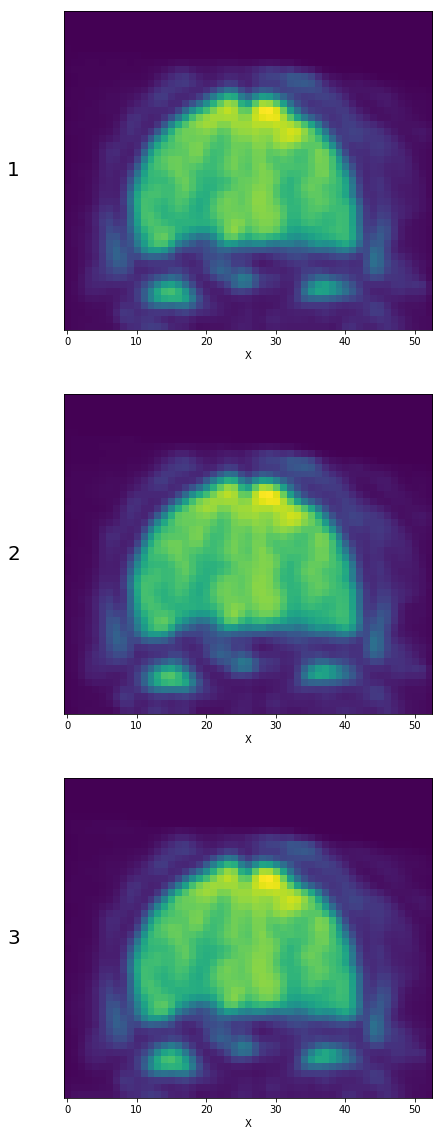

In [36]:
FunctionalData3D.plot_data(data, [1,2,3], axis='Y', pos=54)

### Create a design matrix for the localizer data

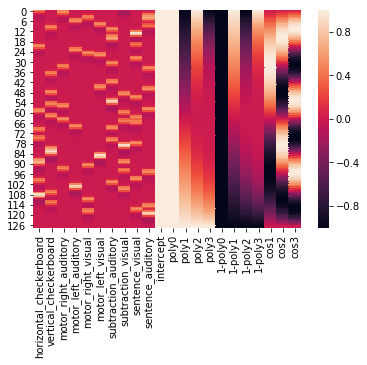

In [37]:
design_matrix_localizer = DesignMatrixUtils.create_design_matrix(events, labels)

motor_design_matrix = select_tasks_with_name(design_matrix_localizer, 'motor')

#DesignMatrixUtils.plot(motor_design_matrix, orientation='vertical')
#DesignMatrixUtils.heatmap(motor_design_matrix)
#DesignMatrixUtils.plot(convolve_hrf(design_matrix_localizer), orientation='vertical')

#design_matrix_localizer_hrf = DesignMatrixUtils.convolve_hrf(design_matrix_localizer, 2.4)
#DesignMatrixUtils.heatmap(design_matrix_localizer_hrf)

funcs = [
    lambda dm : DesignMatrixUtils.convolve_hrf(dm, 2),
    lambda dm : DesignMatrixUtils.add_intercept(dm),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 2, flipped = True),
    lambda dm : DesignMatrixUtils.add_poly(dm, degrees = 3, flipped = True),  
    lambda dm : DesignMatrixUtils.add_cosine(dm, 1, 1),
    lambda dm : DesignMatrixUtils.add_cosine(dm, 2, 1),    
    lambda dm : DesignMatrixUtils.add_cosine(dm, 3, 1),        
]

design_matrix_localizer_full = DesignMatrixUtils.add_many(design_matrix_localizer, funcs)
DesignMatrixUtils.heatmap(design_matrix_localizer_full)

# design_matrix_motor_full = DesignMatrixUtils.add_many(motor_design_matrix, funcs)
# DesignMatrixUtils.heatmap(design_matrix_motor_full)


## So, back to the question, which regions are more involved with visual compared to auditory sensory processing?

In [15]:
# This takes a while to calculate
beta_map_visual_vs_aud = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


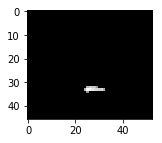

In [38]:
#FunctionalData3D.plot_beta_map(beta_map_visual_vs_aud, design_matrix_localizer_full)
# FunctionalData3D.show_contrast(beta_map_visual_vs_aud, [1,1,-1,-1,1,1,-1,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=50)
z = FunctionalData3D.show_contrast_with_threshold(beta_map_visual_vs_aud, [1,1,-1,-1,1,1,-1,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=10, threshold=.1)


## Which regions are more involved in processing numbers compared to words?

In [17]:
# This takes a while to calculate
beta_map_nums_vs_words = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


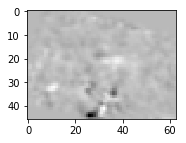

In [18]:
#FunctionalData3D.plot_beta_map(beta_map_nums_vs_words, design_matrix_localizer_full)
z = FunctionalData3D.show_contrast(beta_map_nums_vs_words, [0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='x', pos=30) # Assumes "subtraction_visual" is the only number task, "sentence_visual/auditory" are only word tasks


## Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?

In [19]:
# This takes a while to calculate
beta_map_motor_vs_cog = FunctionalData3D.compute_beta_map(data, design_matrix_localizer_full.values)


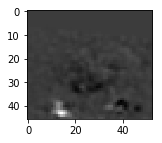

In [40]:
#FunctionalData3D.plot_beta_map(beta_map_motor_vs_cog, design_matrix_localizer_full)
z = FunctionalData3D.show_contrast(beta_map_motor_vs_cog, [0,0,1,1,1,1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0], axis='y', pos=60)


## Extend the lab with requested features
 - Sliders to explore slices (/)
     - Default slider value on most active slice (/)
     
     
 - Generate contrast vector from string input (/)
 
 
 - Select voxel and show crosshairs in all 3 axes (NOT INTERACTIVELY) (/)
 
 
 - Return coordinates of top cluster for each contrast
     - ndimage clustering method
 

In [21]:
def contrast_vector_from_name(design_matrix, pos_name, neg_name):
    contrast_vector = np.zeros(design_matrix.shape[1])
    cols = design_matrix.columns
    
    for i,col in enumerate(cols):
        if (pos_name in col):
            contrast_vector[i] = 1
        elif (neg_name in col):
            contrast_vector[i] = -1
            
    # Hardcodings
    if (pos_name == "visual"):
        contrast_vector[0] = 1 # horizontal checkerboard
        contrast_vector[1] = 1 # vertical checkerboard
    if (neg_name == "visual"):
        contrast_vector[0] = -1 # horizontal checkerboard
        contrast_vector[1] = -1 # vertical checkerboard
    if ("number" in pos_name):
        contrast_vector[6] = 1 # subtraction_auditory 
        contrast_vector[7] = 1 # subtraction_visual
    if ("number" in neg_name):
        contrast_vector[6] = -1 # subtraction_auditory 
        contrast_vector[7] = -1 # subtraction_visual
    if ("word" in pos_name):
        contrast_vector[8] = 1 # sentence_visual
        contrast_vector[9] = 1 # sentence_auditory
    if ("word" in neg_name):
        contrast_vector[8] = -1 # sentence_visual
        contrast_vector[9] = -1 # sentence_auditory
    if ("cog" in pos_name):
        contrast_vector[6] = 1 # subtraction_auditory 
        contrast_vector[7] = 1 # subtraction_visual
        contrast_vector[8] = 1 # sentence_visual
        contrast_vector[9] = 1 # sentence_auditory
    if ("cog" in neg_name):
        contrast_vector[6] = -1 # subtraction_auditory 
        contrast_vector[7] = -1 # subtraction_visual
        contrast_vector[8] = -1 # sentence_visual
        contrast_vector[9] = -1 # sentence_auditory
        
    # TODO: make the numbers add up to 0
    return contrast_vector
    
    
cs = contrast_vector_from_name(design_matrix_localizer_full, "visual", "aud")
print(cs)

[ 1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]


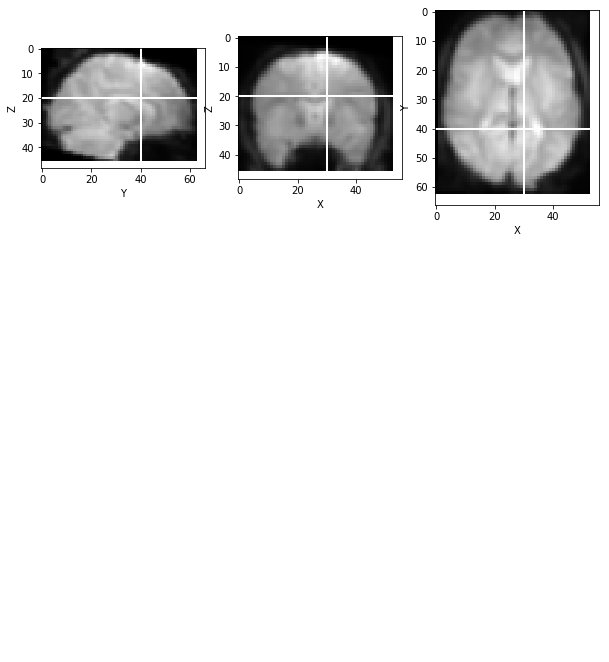

In [60]:
def show_voxel_with_crosshairs(data, x, y, z, t, beta = False):
    # if beta is True, search for interesting regions (max)
    if beta:
        shape = data.shape
    else:
        shape = data.get_fdata().shape
    xLength = shape[0]
    yLength = shape[1]
    zLength = shape[2]
    
    xIndex = x
    yIndex = y
    zIndex = z
    timeSlice = t
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1, xlabel='Y', ylabel='Z')  
    if beta:
        imgX = data[xIndex,:,:,timeSlice]
    else:
        imgX = data.get_fdata()[xIndex,:,:,timeSlice]
    rotated_imgX = ndimage.rotate(imgX, 90)
    plt.imshow(rotated_imgX, 'gray', interpolation='none')
    plt.plot([0,yLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([yIndex,yIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 245, 'x={}'.format(x), fontsize=12, color='white')
    
    plt.subplot(1,3,2, xlabel='X', ylabel='Z')
    if beta:
        imgY = data[:,yIndex,:,timeSlice]
    else:
        imgY = data.get_fdata()[:,yIndex,:,timeSlice]
    rotated_imgY = ndimage.rotate(imgY, 90)
    plt.imshow(rotated_imgY, 'gray', interpolation='none')
    plt.plot([0,xLength],[zIndex,zIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,zLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'y={}'.format(y), fontsize=12, color='white')
    
    plt.subplot(1,3,3, xlabel='X', ylabel='Y')
    if beta:
        imgZ = data[:,:,zIndex,timeSlice]
    else:
        imgZ = data.get_fdata()[:,:,zIndex,timeSlice]
    rotated_imgZ = ndimage.rotate(imgZ, 90)
    plt.imshow(rotated_imgZ, 'gray', interpolation='none')
    plt.plot([0,xLength],[yIndex,yIndex],'w-', linestyle = "-", lw=2)
    plt.plot([xIndex,xIndex],[0,yLength],'w-', linestyle = "-", lw=2)
    plt.text(10, 175, 'z={}'.format(z), fontsize=12, color='white')
    
    plt.show()
    
show_voxel_with_crosshairs(data, 30, 40, 20, 5)

In [77]:
@interact(x=(0,52), y=(0,62), z=(0,45), t=(0,127))
def interact_with_voxels(x=1, y=1, z=1, t=1):
    show_voxel_with_crosshairs(data, x, y, z, t, beta=False)

interactive(children=(IntSlider(value=1, description='x', max=52), IntSlider(value=1, description='y', max=62), IntSlider(value=1, description='z', max=45), IntSlider(value=1, description='t', max=127), Output()), _dom_classes=('widget-interact',))

In [76]:
def sum_image_values(img):
    assert(len(img.shape)==2)
    return np.sum(img)

## Find maximum slices in beta map. Remember shape is: (53, 63, 46, 22)
def find_most_active_regions(beta_map):
    xLength = beta_map.shape[0]
    yLength = beta_map.shape[1]
    zLength = beta_map.shape[2]
    tLength = beta_map.shape[3]
    
    # Find max X image
    maxX = float("-inf")
    xVal = -1
    tXVal = -1
    for x in range(xLength):
        for t in range(tLength):
            betaImg = beta_map[x,:,:,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxX):
                maxX = imgSum
                xVal = x
                tXVal = t
                
    # Find max Y image
    maxY = float("-inf")
    yVal = -1
    tYVal = -1
    for y in range(yLength):
        for t in range(tLength):
            betaImg = beta_map[:,y,:,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxY):
                maxY = imgSum
                yVal = y
                tYVal = t
    
    # Find max Z image
    maxZ = float("-inf")
    zVal = -1
    tZVal = -1
    for z in range(zLength):
        for t in range(tLength):
            betaImg = beta_map[:,:,z,t]
            imgSum = sum_image_values(betaImg)
            if (imgSum > maxZ):
                maxZ = imgSum
                zVal = z
                tZVal = t
                
    # Use t that maximizes the sum of all three axis slices
    maxT = float("-inf")
    tVal = -1
    for t in [tXVal, tYVal, tZVal]:
        xSum = sum_image_values(beta_map[xVal,:,:,t])
        ySum = sum_image_values(beta_map[:,yVal,:,t])
        zSum = sum_image_values(beta_map[:,:,zVal,t])
        tSum = xSum + ySum + zSum
        if (tSum > maxT):
            tVal = t
    
    return xVal,yVal,zVal,tVal
    
x,y,z,t = find_most_active_regions(beta_map_motor_vs_cog)
# print(x)
# print(y)
# print(z)
# print(t)

In [78]:
xStart,yStart,zStart,tStart = find_most_active_regions(beta_map_motor_vs_cog)

@interact(x=(0,52), y=(0,62), z=(0,45), t=(0,21))
def interact_with_voxels(x=xStart, y=yStart, z=zStart, t=tStart):
    show_voxel_with_crosshairs(beta_map_motor_vs_cog, x, y, z, t, True)

interactive(children=(IntSlider(value=28, description='x', max=52), IntSlider(value=24, description='y', max=62), IntSlider(value=20, description='z', max=45), IntSlider(value=10, description='t', max=21), Output()), _dom_classes=('widget-interact',))